In [9]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer

# Data base import

In [10]:
train_data = pd.read_csv(Path("../data/samples/sample_1000_train.csv")).to_numpy()
validation_data = pd.read_csv(Path("../data/samples/sample_100_validation.csv")).to_numpy()

In [11]:
print(train_data.shape, validation_data.shape)

(1000, 4) (100, 4)


In [12]:
from utils.clean_data import clean_data 

train_data = clean_data(train_data)
traivalidation_data = clean_data(validation_data)

In [13]:
print(train_data.shape, validation_data.shape)

(966, 4) (100, 4)


# Pre-processing

In [103]:
from descriptors.load_data import load_data
from descriptors.data_descriptor import convert_labels

ALPHANUM_ONLY = False
WORD_SIZE = 30
SENTENCE_SIZE = 50
FILL_WITH = "$"
SPLIT_PUNCTUATION = False  # to tell wheter the puncutation "!?.;,/" etc are keeped sticked to a word or not
FEELING_WEIGHT = 0

X_TR_STRING, X_TR_SCALAR = load_data(
    train_data, WORD_SIZE, SENTENCE_SIZE, FILL_WITH, SPLIT_PUNCTUATION, ALPHANUM_ONLY, FEELING_WEIGHT
)
X_TR_ORIGINAL = train_data[:, 1]
Y_TR = convert_labels(train_data, SENTENCE_SIZE, SPLIT_PUNCTUATION)

X_VAL_STRING, X_VAL_SCALAR = load_data(
    validation_data, WORD_SIZE, SENTENCE_SIZE, FILL_WITH, SPLIT_PUNCTUATION, ALPHANUM_ONLY, FEELING_WEIGHT
)
X_VAL_ORIGINAL = validation_data[:, 1]
Y_VAL = convert_labels(validation_data, SENTENCE_SIZE, SPLIT_PUNCTUATION)

In [104]:
print(train_data.shape, X_TR_STRING.shape, X_TR_SCALAR.shape, Y_TR.shape)

print("\nOriginal data :")
print(X_TR_ORIGINAL[0])
print("\nFilled sentence :")
print(X_TR_STRING[0])
print("\nLabel :")
print(Y_TR[0])
print("\nDescriptor :")
print(X_TR_SCALAR[0])

(966, 4) (966, 50) (966, 1501) (966, 50)

Original data :
i feel really weird

Filled sentence :
['i$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' 'feel$$$$$$$$$$$$$$$$$$$$$$$$$$'
 'really$$$$$$$$$$$$$$$$$$$$$$$$' 'weird$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$' '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$'
 '$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

### Standardisation

In [16]:
mu = np.concatenate([X_TR_SCALAR[:, :-1].mean(axis=0), [0]])
sigma = X_TR_SCALAR[:, :-1].std(axis=0)

X_TR_SCALAR = X_TR_SCALAR - mu
X_VAL_SCALAR = X_VAL_SCALAR - mu

for i in range(len(sigma)):
    if sigma[i] != 0:
        X_TR_SCALAR[:, i] /= sigma[i]
        X_VAL_SCALAR[:, i] /= sigma[i]

# Classification

In [17]:
#!pip install xgboost

In [97]:
from sklearn.multioutput import MultiOutputRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [98]:
# nb_neighbors = 10
# regressor = KNeighborsRegressor(nb_neighbors, weights="distance", metric="jaccard")
# regressor = KNeighborsRegressor(nb_neighbors, weights="distance")

regressor = MultiOutputRegressor(
    xgb.XGBClassifier(objective="reg:logistic")
)

#regressor = MultiOutputRegressor(
#    SVR(kernel="poly", degree=2)
#)

regressor.fit(X_TR_SCALAR, Y_TR)

MultiOutputRegressor(estimator=XGBClassifier(base_score=None, booster=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, gamma=None,
                                             gpu_id=None,
                                             importance_type='gain',
                                             interaction_constraints=None,
                                             learning_rate=None,
                                             max_delta_step=None,
                                             max_depth=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             n_estimators=100, n_jobs=None,
                                             num_parallel_tree=None,
               

In [88]:
predictions = regressor.predict(X_VAL_SCALAR)

In [89]:
from utils.post_processing import preds_to_strings

results_val = preds_to_strings(X_VAL_ORIGINAL, X_VAL_STRING, predictions)

In [90]:
from utils.loss import mean_jaccard

accuracy = mean_jaccard(validation_data[:, 2], results_val)
print(accuracy)

54.91143568494593


In [94]:
def test_param(n):
    regressor = KNeighborsRegressor(n, weights="distance", metric="jaccard")
    regressor.fit(X_TR_SCALAR, Y_TR)
    predictions = regressor.predict(X_VAL_SCALAR)
    results_val = preds_to_strings(X_VAL_ORIGINAL, X_VAL_STRING, predictions)
    accuracy = mean_jaccard(validation_data[:, 2], results_val)
    
    return accuracy

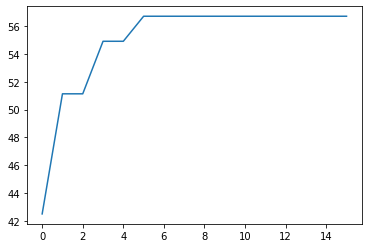

In [95]:
y =[]
for i in range(2,50, 3):
    y.append(test_param(i))
plt.plot(y)
plt.show()